In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
candles = pd.read_csv('../data/new/forecast_data/candles.csv')
print('candles', candles.shape)
# candles['begin'] = pd.to_datetime(candles['begin'])

candles_2 = pd.read_csv('../data/new/forecast_data/candles_2.csv')
print('candles_2', candles_2.shape)

news = pd.read_csv('../data/new/forecast_data/news.csv')
print('news', news.shape)

news_2 = pd.read_csv('../data/new/forecast_data/news_2.csv')
print('news_2', news_2.shape)

candles (24197, 7)
candles_2 (1745, 7)
news (25425, 4)
news_2 (2030, 3)


In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import yake
from typing import List, Dict, Tuple
import warnings
# warnings.filterwarnings('ignore')

# NLP Новости

In [ ]:
import re
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool, cpu_count

# =========================
# Класс TickerRAGSystem
# =========================
class TickerRAGSystem:
    INDUSTRY_DESCRIPTIONS: Dict[str, List[str]] = {
        'нефтегазовая': ['нефть', 'газ', 'скважина', 'месторождение', 'трубопровод', 'нефтедобыча'],
        'банковская': ['банк', 'кредит', 'вклад', 'ипотека', 'финансы', 'расчетный счет'],
        'металлургическая': ['металл', 'сталь', 'алюминий', 'никель', 'медь', 'руда'],
        'ритейл': ['магазин', 'розница', 'продажи', 'сеть', 'торговля', 'ритейлер'],
        'телекоммуникации': ['связь', 'интернет', 'телефон', 'мобильный', 'телеком'],
        'транспорт': ['авиаперевозки', 'аэропорт', 'рейс', 'транспорт', 'логистика'],
        'горнодобывающая': ['шахта', 'рудник', 'добыча', 'полезные ископаемые', 'горнодобывающая'],
        'IT': ['интернет', 'технологи', 'поиск', 'it', 'программное обеспечение'],
        'энергетика': ['электроэнергия', 'энергетика', 'электростанция', 'энергосбыт'],
        'химическая': ['химия', 'удобрения', 'пластмассы', 'химическая продукция'],
        'фармацевтическая': ['фармацевтика', 'лекарства', 'медицинские препараты'],
        'строительная': ['строительство', 'строительная компания', 'строительные материалы'],
        'агропромышленная': ['сельское хозяйство', 'агропром', 'агробизнес'],
        'машиностроение': ['машиностроение', 'машиностроительный завод', 'машиностроительная компания']
    }

    SPECIFIC_KEYWORDS: Dict[str, List[str]] = {
        'сбербанк': ['сбер', 'банк', 'финансы', 'кредит', 'ипотека', 'sberbank'],
        'газпром': ['газ', 'трубопровод', 'газодобыча', 'gazprom'],
        'лукойл': ['нефть', 'бензин', 'топливо', 'lukoil'],
        'норильский никель': ['никель', 'медь', 'металл', 'nornickel'],
        'роснефть': ['нефть', 'роснефти', 'rosneft'],
        'аэрофлот': ['авиа', 'рейс', 'аэропорт', 'aeroflot'],
        'московская биржа': ['биржа', 'мосбиржа', 'торги', 'moex'],
        'втб': ['втб банк', 'vtb'],
        'магнит': ['ритейл', 'магазин', 'сеть магазинов', 'magnit'],
        'мтс': ['связь', 'мобильная связь', 'mts'],
        'тинькофф': ['банк', 'онлайн банк', 'tinkoff'],
        'яндекс': ['поиск', 'интернет', 'yandex'],
    }

    ENGLISH_MAPPING: Dict[str, str] = {
        'газпром': 'gazprom', 'лукойл': 'lukoil', 'сбербанк': 'sberbank',
        'роснефть': 'rosneft', 'норильский никель': 'nornickel',
        'аэрофлот': 'aeroflot', 'алроса': 'alrosa', 'татнефть': 'tatneft',
        'яндекс': 'yandex', 'мвидео': 'mvideo', 'московская биржа': 'moscow exchange',
        'втб': 'vtb', 'магнит': 'magnit', 'мтс': 'mts', 'фосагро': 'phosagro'
    }

    ABBREV_MAPPING: Dict[str, str] = {
        'сбербанк': 'сбер', 'московская биржа': 'мосбиржа',
        'норильский никель': 'норильск', 'мвидео': 'м.видео',
        'роснефть': 'росснефть'
    }

    def __init__(self, ticker_mapping: Dict[str, str]):
        self.ticker_mapping = ticker_mapping
        self.keyword_to_industry = {kw: ind for ind, kws in self.INDUSTRY_DESCRIPTIONS.items() for kw in kws}
        self.company_knowledge_base = self._build_knowledge_base()
        self.alias_to_ticker = {
            alias: ticker
            for ticker, info in self.company_knowledge_base.items()
            for alias in info['aliases']
        }
        self._vectorize_knowledge_base()

    # =========================
    # Построение базы знаний
    # =========================
    def _build_knowledge_base(self) -> Dict[str, Dict]:
        kb = {}
        for company_name, ticker in self.ticker_mapping.items():
            industry = self._detect_industry(company_name)
            kb[ticker] = {
                'company_name': company_name,
                'ticker': ticker,
                'industry': industry,
                'keywords': self._generate_company_keywords(company_name, industry),
                'aliases': self._generate_aliases(company_name)
            }
        return kb

    def _detect_industry(self, company_name: str) -> str:
        for word in company_name.lower().split():
            if word in self.keyword_to_industry:
                return self.keyword_to_industry[word]
        return "другая"

    def _generate_company_keywords(self, company_name: str, industry: str) -> List[str]:
        kws = set([company_name.lower(), *company_name.lower().split()])
        if industry in self.INDUSTRY_DESCRIPTIONS:
            kws.update(self.INDUSTRY_DESCRIPTIONS[industry])
        if company_name in self.SPECIFIC_KEYWORDS:
            kws.update(self.SPECIFIC_KEYWORDS[company_name])
        return list(kws)

    def _generate_aliases(self, company_name: str) -> List[str]:
        aliases = {company_name.lower()}
        if company_name in self.ENGLISH_MAPPING:
            aliases.add(self.ENGLISH_MAPPING[company_name])
        if company_name in self.ABBREV_MAPPING:
            aliases.add(self.ABBREV_MAPPING[company_name])
        return list(aliases)

    # =========================
    # Векторизация TF-IDF
    # =========================
    def _vectorize_knowledge_base(self):
        self.company_tickers = []
        descriptions = []
        for ticker, info in self.company_knowledge_base.items():
            desc = f"{info['company_name']} {info['industry']} {' '.join(info['keywords'])}"
            descriptions.append(desc)
            self.company_tickers.append(ticker)
        self.tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(descriptions)

    # =========================
    # Батчевые методы
    # =========================
    def retrieve_relevant_companies_batch(self, texts: List[str], top_k: int = 5) -> List[List[Tuple[str, float]]]:
        vecs = self.tfidf_vectorizer.transform(texts)
        sims = cosine_similarity(vecs, self.tfidf_matrix)
        results = []
        for sim_row in sims:
            idxs = np.argsort(sim_row)[::-1][:top_k]
            results.append([(self.company_tickers[i], sim_row[i]) for i in idxs if sim_row[i] > 0.1])
        return results

    def extract_direct_tickers_batch(self, texts: List[str]) -> List[List[str]]:
        pattern = re.compile(r'\b([A-Z]{3,5})\b')
        results = []
        for text in texts:
            matches = [m for m in pattern.findall(text) if m in self.ticker_mapping.values()]
            results.append(matches)
        return results

    def extract_aliases_batch(self, texts: List[str]) -> List[List[str]]:
        pattern = re.compile(r'\b(' + '|'.join(map(re.escape, self.alias_to_ticker.keys())) + r')\b')
        results = []
        for text in texts:
            found = {self.alias_to_ticker[m] for m in pattern.findall(text.lower())}
            results.append(list(found))
        return results

    # =========================
    # Основной метод
    # =========================
    def extract_tickers_with_flags_batch(self, texts: List[str]) -> List[Dict[str, any]]:
        alias_results = self.extract_aliases_batch(texts)
        direct_results = self.extract_direct_tickers_batch(texts)
        tfidf_results = self.retrieve_relevant_companies_batch(texts)

        final_results = []
        for i in range(len(texts)):
            tickers = set()
            tickers.update([t for t, _ in tfidf_results[i]])
            tickers.update(alias_results[i])
            tickers.update(direct_results[i])
            flags = {t: (t in tickers) for t in self.ticker_mapping.values()}
            final_results.append({'tickers': list(tickers), 'flags': flags})
        return final_results

# =========================
# DataFrame Processing
# =========================
def process_chunk(args):
    df_chunk, text_column, ticker_mapping = args
    extractor = TickerRAGSystem(ticker_mapping)
    results = extractor.extract_tickers_with_flags_batch(df_chunk[text_column].tolist())
    tickers_col = [r['tickers'] for r in results]
    flags_df = pd.DataFrame([r['flags'] for r in results])
    df_chunk = df_chunk.copy()
    df_chunk['tickers'] = tickers_col
    df_chunk = pd.concat([df_chunk, flags_df], axis=1)
    return df_chunk

def apply_to_dataframe_with_flags(df: pd.DataFrame, text_column: str, ticker_mapping: Dict[str, str], n_jobs=None) -> pd.DataFrame:
    if n_jobs is None:
        n_jobs = max(1, cpu_count() - 1)
    chunks = np.array_split(df, n_jobs)
    args = [(chunk, text_column, ticker_mapping) for chunk in chunks]
    with Pool(n_jobs) as pool:
        df_list = pool.map(process_chunk, args)
    return pd.concat(df_list, ignore_index=True)


In [ ]:
ticker_mapping = {
    'аэрофлот': 'AFLT',
    'алроса': 'ALRS', 
    'газпром': 'GAZP',
    'лукойл': 'LKOH',
    'сбербанк': 'SBER',
    'роснефть': 'ROSN',
    'норильский никель': 'GMKN',
    'московская биржа': 'MOEX',
    'втб': 'VTBR',
    'магнит': 'MGNT',
    'мтс': 'MTSS',
    'татнефть': 'TATN',
    'фосагро': 'PHOR',
    'полюс': 'PLZL',
    'русал': 'RUAL',
    'северсталь': 'CHMF',
    'новатэк': 'NVTK'
}

# Применяем к датафрейму с созданием флагов
news_train_with_flags = apply_to_dataframe_with_flags(
    df=news,
    text_column='publication',
    ticker_mapping=ticker_mapping
)

In [ ]:
import re
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

class EnhancedNewsAnalyzer:
    """
    Улучшенный анализатор с расширенным поиском источников и финансового контекста
    """
    
    def __init__(self):
        print("✅ Улучшенный анализатор инициализирован")
    
    def analyze_sentiment_improved(self, text: str) -> Dict[str, Any]:
        """
        Улучшенный анализ тональности для финансовых новостей
        """
        if not text or not isinstance(text, str):
            return self._neutral_result()
        
        text_lower = text.lower()
        
        positive_indicators = {
            'выгодно': 4, 'выгодн': 3, 'преимуществ': 3, 'перспектив': 3,
            'рекомендац': 4, 'покупай': 4, 'инвестиру': 3, 'лидер': 3,
            'рекорд': 4, 'прорыв': 4, 'успешн': 3, 'эффективн': 2,
            
            'прибыль': 3, 'доход': 3, 'выручк': 3, 'дивиденд': 3,
            'рентабельност': 3, 'доходност': 3, 'профицит': 3,
            'стабильн': 2, 'комфортн': 2, 'уверен': 2,
            
            'рост': 3, 'увелич': 3, 'повыш': 3, 'улучш': 3,
            'развит': 2, 'расширен': 2, 'прогресс': 2,
            
            'позитив': 3, 'оптимизм': 3, 'перспективн': 3,
            'сильн': 2, 'успех': 3, 'достижен': 2
        }
        
        negative_indicators = {
            'проблем': 3, 'риск': 3, 'убыток': 4, 'потер': 3,
            'кризис': 4, 'опасн': 3, 'угроз': 3, 'сложност': 2,
            'трудност': 2, 'нестабильн': 3, 'волатильн': 2,
            
            'паден': 3, 'сниж': 3, 'сокращ': 3, 'уменьш': 3,
            'ухудш': 3, 'просадк': 3, 'обвал': 4,
            
            'отрицательн': 3, 'негативн': 3, 'плох': 2,
            'слаб': 2, 'критич': 3, 'неблагоприятн': 3
        }
        
        intensifiers = {
            'очень': 1.5, 'крайне': 2.0, 'сильно': 1.5, 'значительн': 1.5,
            'существенн': 1.5, 'резк': 1.5, 'катастрофич': 2.0, 'рекордн': 1.5,
            'масштабн': 1.3, 'высок': 1.2, 'больш': 1.1
        }
        
        context_phrases = {
            'positive': [
                'смотрятся выгодно', 'можно отметить', 'отдельно отметим',
                'комфортная долговая', 'высокая рентабельность', 'стабильный денежный поток',
                'высокие дивиденды', 'дивидендная доходность', 'превысить 10%'
            ],
            'negative': [
                'сложился неблагоприятно', 'сопряжено со сложностями', 
                'основные риски', 'ухудшением конъюнктуры'
            ]
        }
        
        positive_score = 0
        negative_score = 0
        
        for word, weight in positive_indicators.items():
            if word in text_lower:
                count = text_lower.count(word)
                for intensifier, multiplier in intensifiers.items():
                    if f"{intensifier} {word}" in text_lower:
                        positive_score += count * weight * multiplier
                        break
                else:
                    positive_score += count * weight
        
        for word, weight in negative_indicators.items():
            if word in text_lower:
                count = text_lower.count(word)
                for intensifier, multiplier in intensifiers.items():
                    if f"{intensifier} {word}" in text_lower:
                        negative_score += count * weight * multiplier
                        break
                else:
                    negative_score += count * weight
        
        for phrase in context_phrases['positive']:
            if phrase in text_lower:
                positive_score += 5
        
        for phrase in context_phrases['negative']:
            if phrase in text_lower:
                negative_score += 5
        
        total_score = positive_score - negative_score
        
        if total_score >= 2:
            sentiment = 'positive'
            confidence = min((total_score + 5) / 15, 0.95)
        elif total_score <= -3:
            sentiment = 'negative'
            confidence = min((abs(total_score) + 5) / 15, 0.95)
        else:
            sentiment = 'neutral'
            confidence = 0.6
        
        emotional_score = total_score / max(positive_score + negative_score + 1, 10)
        
        return {
            'sentiment': sentiment,
            'confidence': confidence,
            'emotional_score': emotional_score,
            'method': 'improved_financial'
        }
    
    def has_financial_context_enhanced(self, text: str) -> bool:
        """
        УЛУЧШЕННАЯ проверка финансового контекста
        """
        if not text:
            return False
        
        text_lower = text.lower()
        
        financial_terms = [
            'акци', 'акция', 'акций', 'дивиденд', 'котировк', 'курс', 'цена',
            'прибыль', 'убыток', 'выручк', 'доход', 'отчетност', 'квартал',
            
            'млрд', 'млн', 'долл', 'рубл', 'евро', 'процент', 'пункт',
            
            'рост', 'падени', 'инвест', 'портфель', 'рынок', 'бирж',
            'сделка', 'покупк', 'продаж', 'волатильн', 'ликвидност',
            
            'финанс', 'бюджет', 'капзатрат', 'актив', 'пассив', 'баланс',
            'выплат', 'затрат', 'издержк', 'рентабельност', 'доходност',
            
            'долгов', 'нагрузк', 'денежн', 'поток', 'fcf', 'ebitda',
            'мультипликатор', 'конъюнктур', 'налогообложен', 'эмитент',
            'эмисси', 'капитализация', 'облигац', 'купон',
            
            'кредит', 'заем', 'депозит', 'вклад', 'ипотек', 'рефинанс',
            
            'ввп', 'инфляц', 'ключев', 'ставк', 'цб', 'центробанк',
            
            'нефт', 'газ', 'энерг', 'метал', 'горнодобыва', 'телеком',
            'ритейл', 'строительств', 'транспорт', 'хими'
        ]
        
        financial_phrases = [
            'денежный поток', 'долговая нагрузка', 'чистая прибыль',
            'валовая выручка', 'операционная деятельность', 'финансовый результат',
            'отчетность по мсфо', 'дивидендная политика', 'рыночная капитализация',
            'котировки акций', 'биржевые торги', 'инвестиционный портфель',
            'финансовый анализ', 'экономический показатель', 'макроэкономическая ситуация'
        ]
        
        financial_terms_count = 0
        
        for term in financial_terms:
            if term in text_lower:
                financial_terms_count += 1
        
        for phrase in financial_phrases:
            if phrase in text_lower:
                financial_terms_count += 3
        
        financial_contexts = [
            r'\b(?:отчет|отчетность|баланс|прибыль|убыток)[^.]{0,100}',
            r'\b(?:цена|курс|котировки)[^.]{0,100}(?:акци|акций|облигац)',
            r'\b(?:дивиденд|выплата)[^.]{0,100}(?:акционер|прибыль)',
        ]
        
        for pattern in financial_contexts:
            if re.search(pattern, text_lower):
                financial_terms_count += 2
        
        return financial_terms_count >= 3
    
    def _neutral_result(self):
        return {
            'sentiment': 'neutral',
            'confidence': 0.5,
            'emotional_score': 0.0,
            'method': 'fallback'
        }
    
    def analyze_news_comprehensive(self, text: str) -> Dict[str, Any]:
        """
        Комплексный анализ новости с улучшенными алгоритмами
        """
        if not text or not isinstance(text, str):
            return {
                'sentiment': 'neutral',
                'confidence': 0.0,
                'emotional_score': 0.0,
                'has_financial_context': False,
                'method': 'fallback'
            }
        
        sentiment_result = self.analyze_sentiment_improved(text)
        has_financial_context = self.has_financial_context_enhanced(text)
        
        return {
            **sentiment_result,
            'has_financial_context': has_financial_context
        }

def extract_sources_advanced(text: str) -> str:
    """
    Умное извлечение источников с использованием NLP
    """
    extractor = SourceExtractor()
    return extractor.extract_sources_advanced(text)

def reanalyze_with_enhancements(df) -> pd.DataFrame:
    """
    Перезапускаем анализ с улучшенными алгоритмами источников и финансового контекста
    """
    analyzer = EnhancedNewsAnalyzer()
    source_extractor = SourceExtractor()
    
    print("🔄 Перезапускаем анализ с улучшенными алгоритмами...")
    
    analysis_results = df['publication'].apply(analyzer.analyze_news_comprehensive)
    
    df['sentiment'] = analysis_results.apply(lambda x: x['sentiment'])
    df['sentiment_confidence'] = analysis_results.apply(lambda x: x['confidence'])
    df['emotional_score'] = analysis_results.apply(lambda x: x['emotional_score'])
    df['analysis_method'] = analysis_results.apply(lambda x: x['method'])
    df['has_financial_context'] = analysis_results.apply(lambda x: x['has_financial_context'])
    # df['source'] = df['publication'].apply(extract_sources_advanced) # пока не рабочая история
    
    print("✅ Улучшенный анализ завершен!")
    
    return df

In [ ]:
news_features = reanalyze_with_enhancements(news_train_with_flags)

# Дальше модель

In [60]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from catboost import CatBoostRegressor
import pickle

np.random.seed(42)

# ---------------- Новости: лёгкая привязка к тикерам и per-ticker news_count ----------------
def build_ticker_aliases(tickers):
    base = {
        'AFLT': ['аэрофлот', 'aeroflot'],
        'ALRS': ['алроса', 'alrosa'],
        'CHMF': ['северсталь', 'severstal'],
        'GAZP': ['газпром', 'gazprom'],
        'GMKN': ['норникель', 'норильский никель', 'nornickel', 'norilsk nickel'],
        'LKOH': ['лукойл', 'lukoil'],
        'MAGN': ['ммк', 'магнитогорский металлургический комбинат', 'mmk'],
        'MGNT': ['магнит', 'magnit'],
        'MOEX': ['мосбиржа', 'московская биржа', 'moex'],
        'MTSS': ['мтс', 'mts'],
        'NVTK': ['новатэк', 'novatek'],
        'PHOR': ['фосагро', 'phosagro'],
        'PLZL': ['полюс', 'polyus'],
        'ROSN': ['роснефть', 'rosneft'],
        'RUAL': ['русал', 'rusal'],
        'SBER': ['сбер', 'сбербанк', 'sber', 'sberbank'],
        'SIBN': ['газпром нефть', 'gazprom neft'],
        'T':    ['тинькофф', 'т-банк', 'tinkoff', 't-bank'],
        'VTBR': ['втб', 'vtb'],
    }
    return {t: list(set(base.get(t, []) + [t.lower()])) for t in tickers}

def preprocess_sentiment_dummies(news_df):
    """Преобразуем sentiment в one-hot encoding"""
    df = news_df.copy()
    
    # Создаем dummy-переменные для sentiment
    if 'sentiment' in df.columns:
        sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')
        df = pd.concat([df, sentiment_dummies], axis=1)
    
    return df

def tag_news_with_tickers(news_df, ticker_aliases, text_cols=('title','publication')):
    news = news_df.copy()
    news['publish_date'] = pd.to_datetime(news['publish_date'])
    news = preprocess_sentiment_dummies(news)
    
    mentioned_cols = [col for col in news.columns if col.startswith('mentioned_')]
    
    if mentioned_cols:
        def get_mentioned_tickers(row):
            tickers_found = []
            for col in mentioned_cols:
                if row[col] == 1:
                    ticker = col.replace('mentioned_', '')
                    tickers_found.append(ticker)
            return tickers_found
        
        news['tickers'] = news.apply(get_mentioned_tickers, axis=1)
    else:
        news['_text'] = ''
        for c in text_cols:
            if c in news.columns:
                news['_text'] = (news['_text'] + ' ' + news[c].astype(str)).str.lower()
        
        def find_tickers(text):
            if not isinstance(text, str) or not text:
                return []
            found = []
            for tkr, keys in ticker_aliases.items():
                if any(k and k in text for k in keys):
                    found.append(tkr)
            return list(set(found))
        
        news['tickers'] = news['_text'].apply(find_tickers)
        news = news.drop(columns=['_text'])
    
    return news

#фичи новостей
def aggregate_news_features_by_ticker(news_tagged):
    df = news_tagged.copy()
    df['date'] = df['publish_date'].dt.normalize()

    exploded = df.explode('tickers')
    exploded = exploded[exploded['tickers'].notna() & (exploded['tickers'] != '')]

    sentiment_cols = [col for col in exploded.columns if col.startswith('sentiment_')]

    aggregation_dict = {
        'title': 'count',
    }
    if 'sentiment_confidence' in exploded.columns:
        aggregation_dict['sentiment_confidence'] = 'mean'
    if 'emotional_score' in exploded.columns:
        aggregation_dict['emotional_score'] = 'mean'
    if 'has_financial_context' in exploded.columns:
        aggregation_dict['has_financial_context'] = 'sum'

    for col in sentiment_cols:
        aggregation_dict[col] = 'sum'

    agg = exploded.groupby(['tickers', 'date']).agg(aggregation_dict).reset_index()

    rename_map = {
        'tickers': 'ticker',
        'title': 'news_count',
        'sentiment_confidence': 'avg_sentiment_confidence',
        'emotional_score': 'avg_emotional_score',
        'has_financial_context': 'financial_news_count'
    }
    agg = agg.rename(columns=rename_map)

    if 'financial_news_count' in agg.columns:
        agg['financial_news_ratio'] = agg['financial_news_count'] / agg['news_count']
    else:
        agg['financial_news_count'] = 0.0
        agg['financial_news_ratio'] = 0.0

    for col in sentiment_cols:
        if col in agg.columns:
            ratio_col = f'{col}_ratio'
            agg[ratio_col] = agg[col] / agg['news_count']

    agg = agg.fillna(0.0)

    return agg

def aggregate_news_counts_by_ticker(news_tagged):
    df = news_tagged.copy()
    df['date'] = df['publish_date'].dt.normalize()
    exploded = df.explode('tickers')
    exploded = exploded[exploded['tickers'].notna() & (exploded['tickers']!='')]
    agg = exploded.groupby(['tickers','date']).size().reset_index(name='news_count')
    agg = agg.rename(columns={'tickers':'ticker'})

    
    return agg

# добавление фичей
def add_news_features_by_ticker(candles_df, news_df, ticker_aliases):
    candles = candles_df.copy()
    candles['begin'] = pd.to_datetime(candles['begin'])
    candles['date'] = candles['begin'].dt.normalize()
    
    if news_df is None or len(news_df)==0:
        candles['news_count'] = 0.0
        candles['avg_sentiment_confidence'] = 0.0
        candles['avg_emotional_score'] = 0.0
        candles['financial_news_count'] = 0.0
        candles['financial_news_ratio'] = 0.0
        
        return candles.drop(columns=['date'])
    
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    news_features = aggregate_news_features_by_ticker(tagged)
    news_features['date'] += pd.Timedelta(days=1)
    
    out = candles.merge(news_features, on=['ticker','date'], how='left')
    
    news_cols = [col for col in news_features.columns if col not in ['ticker', 'date']]
    
    for col in news_cols:
        out[col] = out[col].fillna(0.0)
    
    expected_sentiments = ['sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_mixed']
    for sent in expected_sentiments:
        if sent not in out.columns:
            out[sent] = 0.0
        if f'{sent}_ratio' not in out.columns:
            out[f'{sent}_ratio'] = 0.0
    
    return out.drop(columns=['date'])

def add_news_count_by_ticker(candles_df, news_df, ticker_aliases):
    candles = candles_df.copy()
    candles['begin'] = pd.to_datetime(candles['begin'])
    candles['date'] = candles['begin'].dt.normalize()
    if news_df is None or len(news_df)==0:
        candles['news_count'] = 0.0
        return candles.drop(columns=['date'])
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    per_ticker = aggregate_news_counts_by_ticker(tagged)
    out = candles.merge(per_ticker, on=['ticker','date'], how='left')
    out['news_count'] = out['news_count'].fillna(0.0)
    return out.drop(columns=['date'])

# ---------------- Фичи и таргеты ----------------
# FEATS = ['momentum_5','volatility_5','price_range','news_count']
FEATS = [
    'momentum_5', 'volatility_5', 'price_range',
    'news_count', 'financial_news_count', 'financial_news_ratio',
    'avg_sentiment_confidence', 'avg_emotional_score',
    'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_mixed',
    'sentiment_positive_ratio', 'sentiment_negative_ratio', 'sentiment_neutral_ratio', 'sentiment_mixed_ratio'
]

def create_features(df):
    df = df.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    df = df.sort_values(['ticker','begin']).reset_index(drop=True)
    df['momentum_5'] = df.groupby('ticker')['close'].pct_change(5).shift(1)
    ret1 = df.groupby('ticker')['close'].pct_change()
    df['volatility_5'] = ret1.groupby(df['ticker']).rolling(5, min_periods=1).std().reset_index(level=0, drop=True)
    df['price_range'] = (df['high'] - df['low'])/df['close']
    
    for c in ['momentum_5','volatility_5','price_range']:
        df[c] = df[c].fillna(0.0)
    
    return df

def create_targets(df, horizons=(1,20)):
    out = df.copy()
    for h in horizons:
        out[f'target_return_{h}d'] = out.groupby('ticker')['close'].pct_change(h).shift(-h)
    return out

# ---------------- Обучение до отсечки ----------------
def fit(candles_train, news_train=None, split_date='2024-09-08', model_path='model.pkl'):
    df = candles_train.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    cutoff = pd.to_datetime(split_date)
    df = df[df['begin'] <= cutoff].copy()

    if len(df) == 0:
        raise ValueError("Train slice after split_date is empty; adjust split_date or inputs.")

    aliases = build_ticker_aliases(sorted(df['ticker'].unique()))

    df = create_features(df)
    df = add_news_features_by_ticker(df, news_train, aliases)
    df = create_targets(df, horizons=(1, 20))

    mask = ~df[[f'target_return_{h}d' for h in (1, 20)]].isna().any(axis=1)
    dft = df.loc[mask].reset_index(drop=True)

    if len(dft) == 0:
        raise ValueError("No valid rows with both targets h=1 and h=20 in train.")

    # X, y
    X = dft.drop(columns=['begin', 'ticker'] + [f'target_return_{h}d' for h in (1, 20)]).values
    feature_names = [c for c in dft.columns if c not in ['begin', 'ticker',
                                                        'target_return_1d', 'target_return_20d']]

    models = {}
    tscv = TimeSeriesSplit(n_splits=5)

    for h in (1, 20):
        y = dft[f'target_return_{h}d'].values

        reg = CatBoostRegressor(
            iterations=1000,
            depth=6,
            learning_rate=0.05,
            loss_function='RMSE',
            random_seed=42,
            verbose=False
        )

        scores = []
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            Xtr, Xval = X[train_idx], X[val_idx]
            ytr, yval = y[train_idx], y[val_idx]
            reg.fit(Xtr, ytr, eval_set=(Xval, yval), use_best_model=True)
            preds = reg.predict(Xval)
            fold_rmse = np.sqrt(np.mean((preds - yval) ** 2))
            scores.append(fold_rmse)
            print(f"[h={h}d] Fold {fold+1}: RMSE={fold_rmse:.4f}")

        print(f"=== Horizon {h}d: CV mean RMSE={np.mean(scores):.4f} ± {np.std(scores):.4f} ===")
        models[f'reg_{h}'] = reg

    with open(model_path, 'wb') as f:
        pickle.dump({
            'features': feature_names,
            'models': models,
            'aliases': aliases,
            'split_date': str(split_date)
        }, f)

# ---------------- Предсказание ровно на t = split_date (одна строка на тикер) ----------------
def _safe_write_csv(df, path):
    df.to_csv(path, index=False, sep=',', encoding='utf-8-sig', lineterminator='\n')  # совместимая запись CSV [web:159]

def predict_on_cutoff(candles_test, news_test=None, model_path='model.pkl', output_path='submission.csv'):
    with open(model_path, 'rb') as f:
        payload = pickle.load(f)
        
    feats   = payload['features']
    models  = payload['models']
    aliases = payload['aliases']
    split_date = pd.to_datetime(payload['split_date'])
    
    # --- тестовые данные ---
    df = candles_test.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    df = df[df['begin'] > split_date].copy()
    
    df = create_features(df)
    df = add_news_features_by_ticker(df, news_test, aliases)
    
    # только нужные фичи
    X = df[feats].values
    
    # прогнозы для каждого горизонта
    for h in (1, 20):
        reg = models[f'reg_{h}']
        df[f'pred_return_{h}d'] = reg.predict(X)
    
    # сохраняем предсказания
    out = df[['ticker', 'begin', 'pred_return_1d', 'pred_return_20d']]
    out.to_csv(output_path, index=False)
    print(f"✅ Predictions saved to {output_path}")
    return out


In [61]:
# aliases = build_ticker_aliases(sorted(candles['ticker'].unique()))
# df_nw = add_news_count_by_ticker(candles, news, aliases)

In [62]:
news_features = pd.read_parquet('news_features.parquet')
# news_features = preprocess_sentiment_dummies(news_features).drop(['sentiment', 'analysis_method'], axis=1)
print(news_features.shape)
news_features.head(2)

(25425, 27)


,Unnamed: 0,publish_date,title,publication,tickers,mentioned_AFLT,mentioned_ALRS,mentioned_GAZP,mentioned_LKOH,mentioned_SBER,...,mentioned_PHOR,mentioned_PLZL,mentioned_RUAL,mentioned_CHMF,mentioned_NVTK,sentiment,sentiment_confidence,emotional_score,analysis_method,has_financial_context
0,25389,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...,"[GAZP, TATN, ROSN]",False,False,True,False,False,...,False,False,False,False,False,positive,0.95,0.511278,improved_financial,True
1,25388,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...,[],False,False,False,False,False,...,False,False,False,False,False,positive,0.95,0.411111,improved_financial,True


In [63]:
fit(candles, news_features, split_date='2024-09-08', model_path='model.pkl')
predict_on_cutoff(candles, news_features, model_path='model.pkl', output_path='submission.csv')


[h=1d] Fold 1: RMSE=0.0216
[h=1d] Fold 2: RMSE=0.0206
[h=1d] Fold 3: RMSE=0.0218
[h=1d] Fold 4: RMSE=0.0222
[h=1d] Fold 5: RMSE=0.0258
=== Horizon 1d: CV mean RMSE=0.0224 ± 0.0018 ===
[h=20d] Fold 1: RMSE=0.0986
[h=20d] Fold 2: RMSE=0.0964
[h=20d] Fold 3: RMSE=0.0948
[h=20d] Fold 4: RMSE=0.1031
[h=20d] Fold 5: RMSE=0.1135
=== Horizon 20d: CV mean RMSE=0.1013 ± 0.0067 ===
✅ Predictions saved to submission.csv


,ticker,begin,pred_return_1d,pred_return_20d
0,AFLT,2024-09-09,0.000335,0.007654
1,AFLT,2024-09-10,0.000365,0.004206
2,AFLT,2024-09-11,0.000364,0.007213
3,AFLT,2024-09-12,0.000379,0.007369
4,AFLT,2024-09-13,0.000326,0.006927
...,...,...,...,...
4183,VTBR,2025-06-14,0.001380,0.003199
4184,VTBR,2025-06-15,0.001382,0.004132
4185,VTBR,2025-06-16,0.001658,0.007198
4186,VTBR,2025-06-17,0.002254,0.006895


# оцениваем

In [36]:
def prepare_evaluation_data(candles_df, predictions_df, split_date):
    """
    Подготавливает данные для оценки: объединяет предсказания с фактическими ценами
    """
    candles = candles_df.copy()
    predictions = predictions_df.copy()
    
    candles['begin'] = pd.to_datetime(candles['begin'])
    split_date = pd.to_datetime(split_date)
    
    evaluation_data = []
    
    for _, pred_row in predictions.iterrows():
        ticker = pred_row['ticker']
        
        base_price = candles[
            (candles['ticker'] == ticker) & 
            (candles['begin'] <= split_date)
        ].sort_values('begin').iloc[-1]['close']
        
        for horizon in range(1, 21):
            pred_col = f'p{horizon}'
            predicted_return = pred_row[pred_col]
            predicted_price = base_price * (1 + predicted_return)
            
            target_date = split_date + pd.Timedelta(days=horizon)
            actual_data = candles[
                (candles['ticker'] == ticker) & 
                (candles['begin'] > split_date) &
                (candles['begin'] <= target_date)
            ]
            
            if len(actual_data) > 0:
                actual_price = actual_data.sort_values('begin').iloc[-1]['close']
                actual_return = (actual_price - base_price) / base_price
                
                evaluation_data.append({
                    'ticker': ticker,
                    'horizon': horizon,
                    'predicted_return': predicted_return,
                    'actual_return': actual_return,
                    'predicted_price': predicted_price,
                    'actual_price': actual_price,
                    'base_price': base_price
                })
    
    return pd.DataFrame(evaluation_data)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_metrics(evaluation_df):
    """
    Вычисляет все метрики качества прогнозирования
    """
    results = {}
    
    actual_returns = evaluation_df['actual_return']
    predicted_returns = evaluation_df['predicted_return']
    
    results['mse_return'] = mean_squared_error(actual_returns, predicted_returns)
    results['rmse_return'] = np.sqrt(results['mse_return'])
    results['mae_return'] = mean_absolute_error(actual_returns, predicted_returns)
    results['r2_return'] = r2_score(actual_returns, predicted_returns)
    
    direction_correct = ((actual_returns * predicted_returns) > 0) | ((actual_returns == 0) & (predicted_returns == 0))
    results['direction_accuracy'] = direction_correct.mean()
    
    actual_prices = evaluation_df['actual_price']
    predicted_prices = evaluation_df['predicted_price']
    
    results['mse_price'] = mean_squared_error(actual_prices, predicted_prices)
    results['rmse_price'] = np.sqrt(results['mse_price'])
    results['mape_price'] = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
    
    return results

def calculate_metrics_by_horizon(evaluation_df):
    """
    Вычисляет метрики для каждого горизонта прогноза отдельно
    """
    horizons = sorted(evaluation_df['horizon'].unique())
    horizon_metrics = {}
    
    for horizon in horizons:
        horizon_data = evaluation_df[evaluation_df['horizon'] == horizon]
        
        metrics = {
            'mse': mean_squared_error(horizon_data['actual_return'], horizon_data['predicted_return']),
            'mae': mean_absolute_error(horizon_data['actual_return'], horizon_data['predicted_return']),
            'direction_accuracy': ((horizon_data['actual_return'] * horizon_data['predicted_return']) > 0).mean(),
            'count': len(horizon_data)
        }
        horizon_metrics[horizon] = metrics
    
    return horizon_metrics

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(evaluation_df, ticker=None):
    """
    Визуализация предсказаний vs факт
    """
    if ticker:
        data = evaluation_df[evaluation_df['ticker'] == ticker]
        title_suffix = f' - {ticker}'
    else:
        data = evaluation_df
        title_suffix = ' - Все тикеры'
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data['predicted_return'], data['actual_return'], alpha=0.6)
    plt.plot([data['actual_return'].min(), data['actual_return'].max()], 
             [data['actual_return'].min(), data['actual_return'].max()], 'r--')
    plt.xlabel('Предсказанная доходность')
    plt.ylabel('Фактическая доходность')
    plt.title(f'Предсказания vs Факт{title_suffix}')
    
    plt.subplot(1, 3, 2)
    horizon_metrics = calculate_metrics_by_horizon(data)
    horizons = list(horizon_metrics.keys())
    mae_values = [horizon_metrics[h]['mae'] for h in horizons]
    plt.plot(horizons, mae_values, 'o-')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('MAE')
    plt.title('Ошибка по горизонтам')
    
    plt.subplot(1, 3, 3)
    direction_acc = [horizon_metrics[h]['direction_accuracy'] for h in horizons]
    plt.plot(horizons, direction_acc, 'o-', color='green')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('Точность направления')
    plt.title('Точность направления')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(evaluation_df):
    """
    Выводит детальную статистику по метрикам
    """
    overall_metrics = calculate_metrics(evaluation_df)
    horizon_metrics = calculate_metrics_by_horizon(evaluation_df)
    
    print("=" * 50)
    print("ОБЩИЕ МЕТРИКИ КАЧЕСТВА:")
    print("=" * 50)
    print(f"RMSE доходности: {overall_metrics['rmse_return']:.6f}")
    print(f"MAE доходности: {overall_metrics['mae_return']:.6f}")
    print(f"R² доходности: {overall_metrics['r2_return']:.4f}")
    print(f"Точность направления: {overall_metrics['direction_accuracy']:.2%}")
    print(f"MAPE цены: {overall_metrics['mape_price']:.2f}%")
    
    print("\n" + "=" * 50)
    print("МЕТРИКИ ПО ГОРИЗОНТАМ:")
    print("=" * 50)
    for horizon in sorted(horizon_metrics.keys()):
        metrics = horizon_metrics[horizon]
        print(f"Горизонт {horizon:2d}д: MAE={metrics['mae']:.6f}, "
              f"Направление={metrics['direction_accuracy']:.2%}, "
              f"n={metrics['count']}")

In [39]:
def predict_and_save(candles_full, news_full=None, model_path='model.pkl', 
                    predictions_path='predictions.csv', output_path='submission.csv'):
    
    predictions = predict_on_cutoff(candles_full, news_full, model_path, output_path)
    
    # Сохраняем предсказания для последующей оценки
    predictions.to_csv(predictions_path, index=False)
    print(f"Предсказания сохранены в {predictions_path}")
    
    return predictions

submission = predict_and_save(candles, news_features, model_path='model.pkl',
                             predictions_path='predictions.csv',
                             output_path='submission.csv')

Предсказания сохранены в predictions.csv


RMSE доходности: 0.068610    
MAE доходности: 0.052259   
R² доходности: -0.8176   
Точность направления: 80.79%   
MAPE цены: 4.80%   

ОБЩИЕ МЕТРИКИ КАЧЕСТВА:
RMSE доходности: 0.069512
MAE доходности: 0.053227
R² доходности: -0.8657
Точность направления: 76.58%
MAPE цены: 4.89%

МЕТРИКИ ПО ГОРИЗОНТАМ:
Горизонт  1д: MAE=0.030693, Направление=21.05%, n=19
Горизонт  2д: MAE=0.016711, Направление=47.37%, n=19
Горизонт  3д: MAE=0.015186, Направление=63.16%, n=19
Горизонт  4д: MAE=0.018975, Направление=63.16%, n=19
Горизонт  5д: MAE=0.023574, Направление=68.42%, n=19
Горизонт  6д: MAE=0.023444, Направление=68.42%, n=19
Горизонт  7д: MAE=0.023313, Направление=68.42%, n=19
Горизонт  8д: MAE=0.042540, Направление=78.95%, n=19
Горизонт  9д: MAE=0.059432, Направление=84.21%, n=19
Горизонт 10д: MAE=0.046012, Направление=78.95%, n=19
Горизонт 11д: MAE=0.053465, Направление=84.21%, n=19
Горизонт 12д: MAE=0.068231, Направление=84.21%, n=19
Горизонт 13д: MAE=0.067991, Направление=84.21%, n=19
Горизонт 14д: MAE=0.067750, Направление=84.21%, n=19
Горизонт 15д: MAE=0.080746, Направление=89.47%, n=19
Горизонт 16д: MAE=0.091905, Направлен

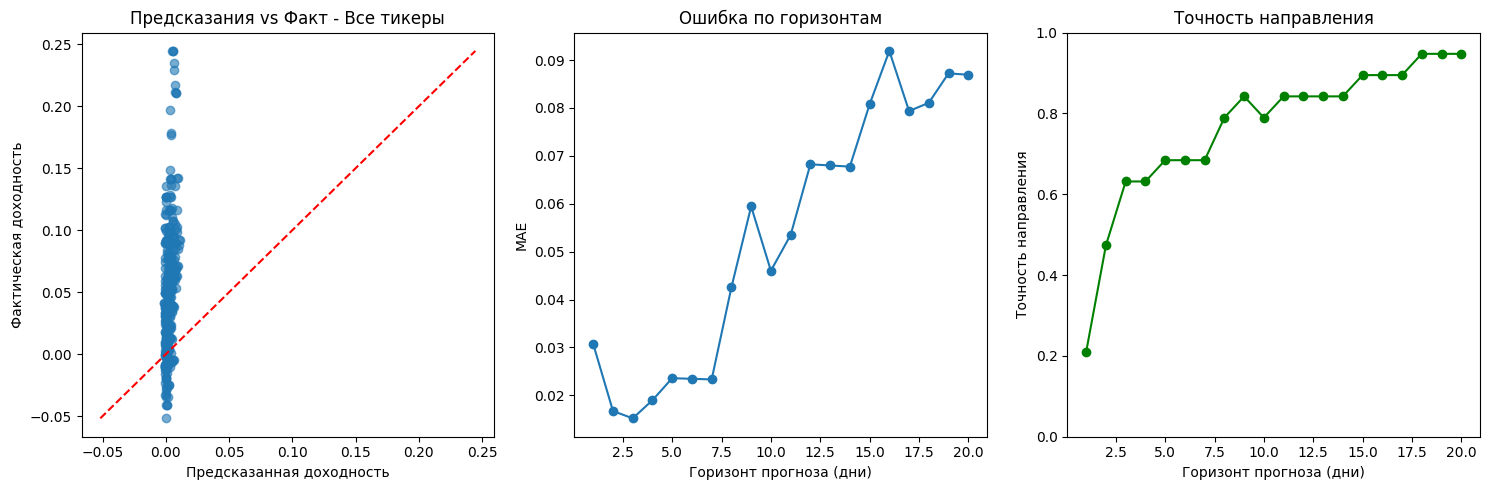

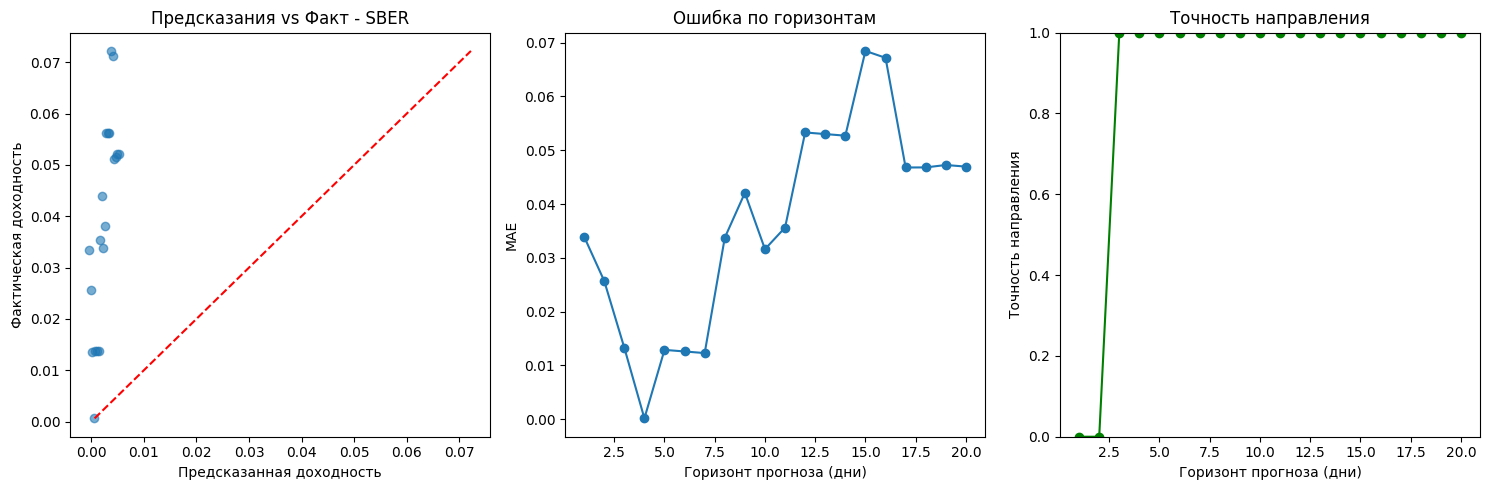

KeyError: 'mse_price'

In [40]:
evaluation_df = prepare_evaluation_data(candles, submission, '2024-09-08')

print_detailed_metrics(evaluation_df)

plot_predictions(evaluation_df)
plot_predictions(evaluation_df, 'SBER')  # для конкретного тикера

best_predictions = evaluation_df.nsmallest(10, 'mse_price')
worst_predictions = evaluation_df.nlargest(10, 'mse_price')